In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 5 — Decision Trees and Variants
## Lesson 4: CHAID and M5 Model Trees

**Course:** Introductory Course of Machine Learning (37 chapters)  
**Chapter:** 5 (Decision Trees and Variants)  
**Lesson:** 4 (CHAID and M5 Model Trees)

This notebook is intentionally **long and practice-heavy**. You will not just read definitions—you will implement simplified versions of two classic tree variants and stress-test them on multiple datasets from your repo:

- **CHAID**: a multiway decision tree based on **chi-square tests of association** (or chi-square statistics if $p$-values are unavailable).
- **M5 Model Trees**: regression trees whose leaves contain **linear models**, producing **piecewise linear** predictions.

Along the way, we connect the ideas to modern ML practice: preprocessing, leakage safety, stability checks, and how to decide when these methods are appropriate.

**MathJax rule (your requirement):** in markdown we use `$...$` and `$$...$$` (not `\\(...\\)` or `\\[...\\]`).

---

## Why these two models belong in the “Decision Trees and Variants” chapter

Decision trees are a template: you recursively partition the input space and make a prediction per region. Many algorithms fit this pattern, but they differ in **how they choose splits** and **what model lives at the leaves**.

- **CART** (common in libraries) chooses binary splits using impurity/variance reduction and predicts a constant at each leaf (majority class or mean).
- **CHAID** chooses (often multiway) splits using **statistical hypothesis tests** and was designed to feel natural for tabular/categorical data analysis.
- **M5** keeps the tree structure but upgrades leaf predictions from a constant to a **linear regression model**—a powerful “middle ground” between linear models and deep nonlinear learners.

If you only learn CART, you’ll often miss:
- the chi-square / contingency-table style reasoning that many analysts expect,
- the piecewise-linear trick that frequently improves regression accuracy while retaining interpretability.

In other words, learning CHAID and M5 expands your “tree toolbox” considerably.

---

## Learning objectives

By the end of this lesson you should be able to:

1. Derive and interpret the chi-square statistic used by CHAID, and explain what the degrees of freedom mean.
2. Explain why CHAID often produces **multiway splits** and why that can be good or bad.
3. Implement a simplified CHAID-like classifier and understand the key engineering knobs:
   - `alpha` (significance threshold, if $p$-values exist)
   - `max_depth`
   - `min_samples_split`, `min_child_size`
   - numeric discretization (`n_bins_numeric`)
4. Understand what “model tree” means and how M5 differs from a regular regression tree:
   - leaf models are linear, not constant
   - smoothing blends local and global predictions
5. Implement a practical M5-like model tree regressor and evaluate it on multiple datasets.
6. Perform stability diagnostics (how often the root split changes) and sensitivity analysis (how performance changes with smoothing).

This notebook uses multiple datasets “randomly” (not a single dataset reused everywhere), per your requirement.

---

## Setup and conventions

We’ll keep code cells **identical** between English and Persian notebooks (your constraint).  
In the Persian notebook:
- chart titles, legends, labels, and any code strings stay in English
- code comments stay in English

All dataset loads use relative paths like `../../../Datasets/...` consistent with your repo.

We also follow a discipline you should apply in all ML work:
- split train/test before doing anything target-dependent
- treat preprocessing as a pipeline where possible
- report multiple metrics and include at least one sanity check plot

In [2]:
import numpy as np
import pandas as pd

import math

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt

# Optional SciPy for chi-square p-values (nice but not strictly required)
try:
    from scipy.stats import chi2_contingency
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

SCIPY_AVAILABLE

True

---

# Part A — CHAID

## A0. CHAID in depth: what “test-driven splitting” really means

### The statistical story

At a node, CHAID looks for a predictor $X$ that is strongly associated with the target $Y$.  
For classification, both $X$ and $Y$ are treated as categorical (even if $X$ is numeric, it is discretized).

The null hypothesis is:

$$
H_0: X \\perp Y
$$

which means “knowing $X$ does not help predict $Y$” (independence). If we reject $H_0$, we treat the predictor as informative and split the node on that predictor.

The chi-square statistic is computed from a contingency table. If expected counts are $E_{ij}$ and observed counts are $O_{ij}$:

$$
\\chi^2 = \\sum_{i,j} \\frac{(O_{ij}-E_{ij})^2}{E_{ij}}
$$

The degrees of freedom (for a $k \\times c$ table) are:

$$
df = (k-1)(c-1)
$$

Intuition:
- larger $\\chi^2$ means “observed table deviates more from independence”
- smaller $p$-value means “this deviation is unlikely under independence”

### Why multiway splits are natural here

A categorical predictor with $k$ categories produces a $k \\times c$ contingency table.  
Splitting into **k** branches preserves those categories directly and is typically more interpretable than forcing a binary partition.

However, multiway splits can overfit if:
- $k$ is large (high-cardinality categories)
- many categories have small sample counts
- you keep splitting deeply without constraints

### Classic CHAID: category merging and multiple-testing corrections

Real CHAID includes two big ideas we do *not* fully implement here:

1. **Category merging**: if two categories have similar target distributions (high pairwise $p$-value), merge them to reduce fragmentation.
2. **Multiple testing correction**: at a node, you may test many features. A classic control is Bonferroni:
   - if you test $m$ features, use $\\alpha' = \\alpha/m$

We will discuss how to implement both as exercises, and we will implement stability checks to partially mitigate the lack of a correction.

## A0.1. Algorithm sketch (pseudo-workflow)

A simplified CHAID-like tree can be described as:

1. **At a node** with samples $(X, y)$:
2. For each candidate feature $f$:
   - If $f$ is numeric: discretize it into bins (e.g., quantiles)
   - Build contingency table between $f$ values and $y$
   - Compute $\\chi^2$ (and $p$ if available)
3. Choose the best feature (largest $\\chi^2$ or smallest $p$).
4. If significance threshold is used and $p > \\alpha$, stop.
5. Split samples by feature values and recurse on children, subject to:
   - max depth
   - min samples split
   - min child size
6. Leaf prediction is majority class (or full distribution).

Engineering note: This model is a good example of how **statistics becomes a split selection heuristic**, similar in spirit to Gini/entropy.

---

## A1. Dataset 1 (classification): `drug200.csv`

We start with a dataset that contains natural categorical predictors—ideal for CHAID-like behavior.

**Path:** `../../../Datasets/Classification/drug200.csv`

Goal: predict `Drug` using `Sex`, `BP`, `Cholesterol`, and numeric features (`Age`, `Na_to_K`).

We will:
1. do quick EDA
2. train a CART baseline
3. train a CHAID-like model on raw columns
4. compare and interpret

In [3]:
drug_path = Path("../../../Datasets/Classification/drug200.csv")
df_drug = pd.read_csv(drug_path)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
target_col = "Drug"
display(df_drug.head())

print("Class distribution:")
display(df_drug[target_col].value_counts())

cat_cols = ["Sex", "BP", "Cholesterol"]
num_cols = ["Age", "Na_to_K"]

for c in cat_cols:
    print(f"\nValue counts for {c}:")
    display(df_drug[c].value_counts())

print("\nNumeric summary:")
display(df_drug[num_cols].describe().T)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


Class distribution:


Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64


Value counts for Sex:


Sex
M    104
F     96
Name: count, dtype: int64


Value counts for BP:


BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64


Value counts for Cholesterol:


Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


### CART baseline (drug200.csv)

In [5]:
X = df_drug.drop(columns=[target_col])
y = df_drug[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

cart = DecisionTreeClassifier(max_depth=4, random_state=42)

cart_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", cart),
])

cart_model.fit(X_train, y_train)
pred_cart = cart_model.predict(X_test)

print("CART Accuracy:", accuracy_score(y_test, pred_cart))
print("\nClassification report:")
print(classification_report(y_test, pred_cart, zero_division=0))

CART Accuracy: 0.98

Classification report:
              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         4
       drugX       1.00      0.92      0.96        13

    accuracy                           0.98        50
   macro avg       0.99      0.98      0.99        50
weighted avg       0.98      0.98      0.98        50



In [6]:
cm = confusion_matrix(y_test, pred_cart, labels=sorted(y.unique()))
pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique()))

,DrugY,drugA,drugB,drugC,drugX
DrugY,23,0,0,0,0
drugA,0,6,0,0,0
drugB,0,0,4,0,0
drugC,0,0,0,4,0
drugX,1,0,0,0,12


### CHAID-like model (drug200.csv)

In [7]:
from dataclasses import dataclass, field
from typing import Any, Dict, Optional, Tuple, List

def _chi2_from_contingency(contingency: np.ndarray) -> Tuple[float, Optional[float], int]:
    """Return (chi2_stat, p_value_or_None, df).

    If SciPy is unavailable, p_value is None and we compute chi2_stat manually.
    """
    contingency = np.asarray(contingency, dtype=float)
    n = contingency.sum()
    if n <= 0:
        return 0.0, None, 0

    row_sums = contingency.sum(axis=1, keepdims=True)
    col_sums = contingency.sum(axis=0, keepdims=True)
    expected = row_sums @ col_sums / n

    with np.errstate(divide='ignore', invalid='ignore'):
        chi2_stat = np.nansum((contingency - expected) ** 2 / expected)

    df = (contingency.shape[0] - 1) * (contingency.shape[1] - 1)

    if SCIPY_AVAILABLE:
        chi2_stat_s, p, dof, exp = chi2_contingency(contingency, correction=False)
        return float(chi2_stat_s), float(p), int(dof)

    return float(chi2_stat), None, int(df)


@dataclass
class CHAIDNode:
    depth: int
    prediction: Any
    class_counts: Dict[Any, int]
    split_feature: Optional[str] = None
    bins: Optional[np.ndarray] = None
    children: Dict[Any, 'CHAIDNode'] = field(default_factory=dict)
    chi2_stat: Optional[float] = None
    p_value: Optional[float] = None

    @property
    def is_leaf(self) -> bool:
        return self.split_feature is None


class SimpleCHAIDClassifier:
    """Educational CHAID-like classifier (multiway, chi-square scoring).

    Notes:
    - This is not a full CHAID implementation: no category merging and no multiple-testing correction.
    - Numeric features are discretized into quantile bins (supervised discretization is an extension).
    """
    def __init__(
        self,
        max_depth: int = 4,
        min_samples_split: int = 20,
        min_child_size: int = 10,
        alpha: float = 0.05,
        n_bins_numeric: int = 4,
        random_state: int = 42,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_child_size = min_child_size
        self.alpha = alpha
        self.n_bins_numeric = n_bins_numeric
        self.random_state = random_state
        self.root_: Optional[CHAIDNode] = None
        self.feature_types_: Dict[str, str] = {}

    def _majority_class(self, y: pd.Series) -> Tuple[Any, Dict[Any, int]]:
        counts = y.value_counts().to_dict()
        pred = max(counts.items(), key=lambda kv: kv[1])[0]
        return pred, counts

    def _discretize_numeric(self, s: pd.Series) -> Tuple[pd.Series, np.ndarray]:
        q = self.n_bins_numeric
        for q_try in range(q, 1, -1):
            try:
                binned, bins = pd.qcut(s, q=q_try, retbins=True, duplicates='drop')
                codes = binned.cat.codes
                return codes, bins
            except Exception:
                continue
        return pd.Series(np.zeros(len(s), dtype=int), index=s.index), np.array([s.min(), s.max()])

    def _best_split(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        features: List[str]
    ) -> Tuple[Optional[str], Optional[np.ndarray], float, Optional[float]]:
        best_feature = None
        best_bins = None
        best_score = -np.inf
        best_p = None

        y_vals = y.astype(str)

        for f in features:
            s = X[f]
            bins = None

            if self.feature_types_[f] == 'numeric':
                s_cat, bins = self._discretize_numeric(s)
                x_vals = s_cat.astype(str)
            else:
                x_vals = s.astype(str).fillna('NA')

            contingency = pd.crosstab(x_vals, y_vals).to_numpy()
            chi2_stat, p, df = _chi2_from_contingency(contingency)

            score = chi2_stat  # maximize chi-square

            if score > best_score:
                best_score = score
                best_feature = f
                best_bins = bins
                best_p = p

        return best_feature, best_bins, best_score, best_p

    def _split_values(self, X: pd.DataFrame, feature: str, bins: Optional[np.ndarray]) -> pd.Series:
        s = X[feature]
        if self.feature_types_[feature] == 'numeric':
            if bins is not None:
                try:
                    binned = pd.cut(s, bins=bins, include_lowest=True)
                    return binned.astype(str).fillna('NA')
                except Exception:
                    pass
            codes, _ = self._discretize_numeric(s)
            return codes.astype(str).fillna('NA')
        return s.astype(str).fillna('NA')

    def _build(self, X: pd.DataFrame, y: pd.Series, depth: int, features: List[str]) -> CHAIDNode:
        pred, counts = self._majority_class(y)
        node = CHAIDNode(depth=depth, prediction=pred, class_counts=counts)

        # stopping rules
        if depth >= self.max_depth:
            return node
        if len(y) < self.min_samples_split:
            return node
        if len(set(y)) == 1:
            return node
        if not features:
            return node

        best_feature, best_bins, best_score, best_p = self._best_split(X, y, features)
        if best_feature is None:
            return node

        # alpha rule (if we have p-values)
        if SCIPY_AVAILABLE and best_p is not None and best_p > self.alpha:
            return node

        split_series = self._split_values(X, best_feature, best_bins)
        groups = split_series.unique().tolist()
        if len(groups) <= 1:
            return node

        for g in groups:
            if (split_series == g).sum() < self.min_child_size:
                return node

        node.split_feature = best_feature
        node.bins = best_bins
        node.chi2_stat = best_score
        node.p_value = best_p

        for g in groups:
            idx = split_series == g
            child = self._build(X.loc[idx], y.loc[idx], depth + 1, features)
            node.children[g] = child

        return node

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.feature_types_.clear()
        for c in X.columns:
            self.feature_types_[c] = 'numeric' if pd.api.types.is_numeric_dtype(X[c]) else 'categorical'
        self.root_ = self._build(X, y, depth=0, features=list(X.columns))
        return self

    def _predict_one(self, x: pd.Series, node: CHAIDNode) -> Any:
        if node.is_leaf:
            return node.prediction

        f = node.split_feature
        assert f is not None

        if self.feature_types_[f] == 'numeric':
            if node.bins is not None:
                try:
                    v = pd.cut(pd.Series([x[f]]), bins=node.bins, include_lowest=True).astype(str).iloc[0]
                except Exception:
                    v = str(x[f])
            else:
                v = str(x[f])
        else:
            v = str(x[f]) if pd.notna(x[f]) else 'NA'

        child = node.children.get(v)
        return node.prediction if child is None else self._predict_one(x, child)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        assert self.root_ is not None
        return np.array([self._predict_one(X.iloc[i], self.root_) for i in range(len(X))])

    def print_tree(self, node: Optional[CHAIDNode] = None, indent: str = ''):
        if node is None:
            node = self.root_
        assert node is not None

        if node.is_leaf:
            print(f"{indent}Leaf(pred={node.prediction}, counts={node.class_counts})")
            return

        ptxt = f", p={node.p_value:.4g}" if node.p_value is not None else ""
        print(f"{indent}Node(split={node.split_feature}, chi2={node.chi2_stat:.3f}{ptxt}, pred={node.prediction})")

        for k, child in node.children.items():
            print(f"{indent}  ├─ if {node.split_feature} == {k}:")
            self.print_tree(child, indent + "  │   ")

In [8]:
chaid = SimpleCHAIDClassifier(
    max_depth=4,
    min_samples_split=20,
    min_child_size=10,
    alpha=0.05,
    n_bins_numeric=4,
    random_state=42
)

chaid.fit(X_train, y_train)
pred_chaid = chaid.predict(X_test)

print("CHAID-like Accuracy:", accuracy_score(y_test, pred_chaid))
print("\nClassification report:")
print(classification_report(y_test, pred_chaid, zero_division=0))

CHAID-like Accuracy: 0.76

Classification report:
              precision    recall  f1-score   support

       DrugY       0.85      1.00      0.92        23
       drugA       0.75      0.50      0.60         6
       drugB       0.00      0.00      0.00         4
       drugC       0.50      0.25      0.33         4
       drugX       0.65      0.85      0.73        13

    accuracy                           0.76        50
   macro avg       0.55      0.52      0.52        50
weighted avg       0.69      0.76      0.71        50



In [9]:
chaid.print_tree()

Node(split=Na_to_K, chi2=130.963, p=3.955e-22, pred=DrugY)
  ├─ if Na_to_K == (6.268, 10.469]:
  │   Node(split=BP, chi2=57.091, p=1.751e-10, pred=drugX)
  │     ├─ if BP == NORMAL:
  │     │   Leaf(pred=drugX, counts={'drugX': 15})
  │     ├─ if BP == LOW:
  │     │   Leaf(pred=drugC, counts={'drugC': 7, 'drugX': 4})
  │     ├─ if BP == HIGH:
  │     │   Leaf(pred=drugA, counts={'drugA': 7, 'drugB': 5})
  ├─ if Na_to_K == (10.469, 13.911]:
  │   Leaf(pred=drugX, counts={'drugX': 18, 'drugA': 10, 'drugB': 5, 'drugC': 4})
  ├─ if Na_to_K == (19.153, 38.247]:
  │   Leaf(pred=DrugY, counts={'DrugY': 38})
  ├─ if Na_to_K == (13.911, 19.153]:
  │   Leaf(pred=DrugY, counts={'DrugY': 30, 'drugX': 4, 'drugB': 2, 'drugC': 1})


### Interpreting the output

After you run the baseline and CHAID-like model:

- Look at the confusion matrix for systematic confusions (e.g., `drugX` vs `drugC`).
- Inspect the CHAID-like tree printout:
  - root split feature often reflects the strongest association
  - branches correspond to categories or numeric bins
- Compare interpretability:
  - CART: binary splits on one-hot indicators
  - CHAID-like: multiway split on the original feature level names

Even if accuracy is similar, interpretability can differ meaningfully.

## A2. Reading a CHAID tree as conditional distributions

A helpful way to interpret a CHAID node is:  
“Given that $X = x_i$, what is the empirical distribution of $Y$?”

For each child branch, you can compute:

$$
\\hat{P}(Y=y_j \\mid X=x_i) = \\frac{\\text{count}(X=x_i, Y=y_j)}{\\text{count}(X=x_i)}
$$

This is the same logic analysts use when reading pivot tables.

In practice:
- branches with very different class distributions are informative
- branches with nearly identical distributions might be merge candidates (classic CHAID)

In [10]:
# Conditional distributions for one feature (example: BP)
tab = pd.crosstab(df_drug["BP"], df_drug["Drug"], normalize="index")
tab

Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,0.493506,0.298701,0.207792,0.00,0.000000
LOW,0.468750,0.000000,0.000000,0.25,0.281250
NORMAL,0.389831,0.000000,0.000000,0.00,0.610169


### Chi-square test demo (contingency table + χ² statistic / p-value)

In [11]:
ct = pd.crosstab(df_drug["BP"], df_drug["Drug"])
display(ct)

chi2_stat, p, df = _chi2_from_contingency(ct.to_numpy())
print("Chi-square stat:", chi2_stat)
print("Degrees of freedom:", df)
print("p-value (None if SciPy unavailable):", p)

Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,38,23,16,0,0
LOW,30,0,0,16,18
NORMAL,23,0,0,0,36


Chi-square stat: 143.2328718496999
Degrees of freedom: 8
p-value (None if SciPy unavailable): 5.0417334144665895e-27


---

## A3. Stability analysis (very important in practice)

One criticism of decision trees is **instability**: small changes in data can change splits.

A simple diagnostic is to repeat train/test splits with different seeds and record:
- accuracy
- which feature appears at the root split

If the root split changes frequently, the tree structure is not robust.  
For interpretability-heavy use cases, instability is a red flag.

We do a small repeated-split test below.

In [12]:
# Stability check: how often does the root split feature change across different random splits?
root_splits = []
accs = []

for seed in range(20):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )
    m = SimpleCHAIDClassifier(max_depth=4, min_samples_split=20, min_child_size=10, alpha=0.05, n_bins_numeric=4, random_state=seed)
    m.fit(X_train_s, y_train_s)
    pred = m.predict(X_test_s)
    accs.append(accuracy_score(y_test_s, pred))
    root_splits.append(m.root_.split_feature if m.root_ is not None else None)

print("Average accuracy:", float(np.mean(accs)))
print("Std accuracy:", float(np.std(accs)))

split_counts = pd.Series(root_splits).value_counts(dropna=False)
print("\nRoot split feature frequency:")
display(split_counts)

Average accuracy: 0.728
Std accuracy: 0.05635601121442148

Root split feature frequency:


Na_to_K    20
Name: count, dtype: int64

---

## A4. Dataset 2 (classification): `stars.csv`

To ensure we are not “overfitting our lesson” to one dataset, we repeat a CHAID-style workflow on a different classification dataset.

**Path:** `../../../Datasets/Classification/stars.csv`

Target: `Type`  
Features include both numeric (e.g., `Temperature`, `L`) and categorical (e.g., `Color`, `Spectral_Class`).

We compare:
- CART baseline (with one-hot)
- CHAID-like model (raw columns, with numeric binning)

In [13]:
stars_path = Path("../../../Datasets/Classification/stars.csv")
df_stars = pd.read_csv(stars_path)
df_stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [14]:
# Target: Type (categorical). Features include numeric and categorical.
target_s = "Type"

Xs = df_stars.drop(columns=[target_s])
ys = df_stars[target_s].astype(str)

cat_cols_s = [c for c in Xs.columns if Xs[c].dtype == "object"]
num_cols_s = [c for c in Xs.columns if c not in cat_cols_s]

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs, ys, test_size=0.25, random_state=42, stratify=ys
)

# CART baseline on stars
preprocess_s = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_s),
        ("num", "passthrough", num_cols_s),
    ]
)

cart_s = Pipeline(steps=[
    ("prep", preprocess_s),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

cart_s.fit(Xs_train, ys_train)
pred_cart_s = cart_s.predict(Xs_test)

print("CART Accuracy (stars):", accuracy_score(ys_test, pred_cart_s))
print("\nClassification report:")
print(classification_report(ys_test, pred_cart_s, zero_division=0))

CART Accuracy (stars): 1.0

Classification report:
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00        10
 Hyper Giants       1.00      1.00      1.00        10
Main Sequence       1.00      1.00      1.00        10
    Red Dwarf       1.00      1.00      1.00        10
 Super Giants       1.00      1.00      1.00        10
 White Dwarf        1.00      1.00      1.00        10

     accuracy                           1.00        60
    macro avg       1.00      1.00      1.00        60
 weighted avg       1.00      1.00      1.00        60



In [15]:
# CHAID-like model on stars (raw columns)
chaid_s = SimpleCHAIDClassifier(max_depth=5, min_samples_split=30, min_child_size=15, alpha=0.05, n_bins_numeric=5, random_state=42)
chaid_s.fit(Xs_train, ys_train)
pred_chaid_s = chaid_s.predict(Xs_test)

print("CHAID-like Accuracy (stars):", accuracy_score(ys_test, pred_chaid_s))
print("\nClassification report:")
print(classification_report(ys_test, pred_chaid_s, zero_division=0))

CHAID-like Accuracy (stars): 0.7333333333333333

Classification report:
               precision    recall  f1-score   support

  Brown Dwarf       0.47      0.70      0.56        10
 Hyper Giants       0.83      1.00      0.91        10
Main Sequence       0.00      0.00      0.00        10
    Red Dwarf       0.75      0.90      0.82        10
 Super Giants       0.82      0.90      0.86        10
 White Dwarf        0.90      0.90      0.90        10

     accuracy                           0.73        60
    macro avg       0.63      0.73      0.67        60
 weighted avg       0.63      0.73      0.67        60



In [16]:
chaid_s.print_tree()

Node(split=R, chi2=480.000, p=4.446e-89, pred=Hyper Giants)
  ├─ if R == (83.2, 1948.5]:
  │   Leaf(pred=Hyper Giants, counts={'Hyper Giants': 30, 'Super Giants': 6})
  ├─ if R == (6.102, 83.2]:
  │   Leaf(pred=Super Giants, counts={'Super Giants': 24, 'Main Sequence': 12})
  ├─ if R == (0.007699999999999999, 0.0914]:
  │   Leaf(pred=White Dwarf , counts={'White Dwarf ': 30, 'Red Dwarf': 6})
  ├─ if R == (0.287, 6.102]:
  │   Leaf(pred=Brown Dwarf, counts={'Brown Dwarf': 18, 'Main Sequence': 18})
  ├─ if R == (0.0914, 0.287]:
  │   Leaf(pred=Red Dwarf, counts={'Red Dwarf': 24, 'Brown Dwarf': 12})


---

## A5. Practical guidance for using CHAID-like trees

### When it’s a strong choice

- Your important predictors are categorical and semantically meaningful.
- You want a “report-style” tree that business users can read.
- You want multiway splits without one-hot fragmentation in the representation.

### When to avoid or modify

- You have very high-cardinality categorical variables (IDs, zip codes).
- You have sparse tables with many small counts.
- You cannot justify repeated testing without correction.

### Guardrails

- enforce `min_child_size` aggressively
- prefer shallow trees for interpretability
- consider merging categories (classic CHAID step)
- run stability checks, not just a single train/test split

---

# Part B — M5 Model Trees

## B0. Why “piecewise linear” is often the sweet spot in tabular regression

A global linear model assumes:

$$
y \approx \beta_0 + \beta^\top x
$$

This can fail when the relationship changes across regions of the feature space.  
A regression tree addresses that by partitioning the space but predicts a constant:

- each leaf prediction is a mean → high bias if local trend is linear

A model tree partitions the space like a tree but predicts a linear function per region:

- lower bias than a constant leaf
- more interpretable than many nonlinear models
- often competitive on tabular datasets

### Connection to basis functions

You can think of a model tree as building “gated” linear models:

- the tree path selects a region (a gate)
- within that region, a linear function applies

This is conceptually similar to mixture-of-experts models, but the gating is a tree rather than a soft probabilistic gate.

### Why smoothing matters

If each region has its own model, predictions can jump abruptly near region boundaries.  
Smoothing blends leaf predictions toward parent predictions:

$$
\\hat{y}_{smooth} = \\frac{n\\hat{y}_{leaf} + k\\hat{y}_{parent}}{n+k}
$$

- $k=0$ means no smoothing (pure leaf model)
- larger $k$ means more influence from ancestors (more stable, possibly more biased)

We will do a sensitivity sweep over `smoothing_k` to see this tradeoff.

In [17]:
from sklearn.tree import _tree

class ModelTreeRegressor:
    """M5-like model tree (educational).

    - Partition is defined by DecisionTreeRegressor.
    - Ridge model is fit at every node.
    - Prediction uses leaf model, then smooths toward ancestors.
    """
    def __init__(self, max_depth=4, min_samples_leaf=10, ridge_alpha=1.0, smoothing_k=15.0, random_state=42):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.ridge_alpha = ridge_alpha
        self.smoothing_k = smoothing_k
        self.random_state = random_state

        self.tree_ = None
        self.node_models_ = {}
        self.node_counts_ = {}
        self.node_means_ = {}

    def _is_sparse(self, X):
        try:
            import scipy.sparse as sp
            return sp.issparse(X)
        except Exception:
            return False

    def _as_1d_row(self, row):
        """Convert a single row (dense or sparse) to a 1D numpy array."""
        if self._is_sparse(row):
            return row.toarray().ravel()
        return np.asarray(row).ravel()

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.tree_ = DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.random_state
        )
        self.tree_.fit(X, y)

        all_idx = np.arange(X.shape[0])
        self._fit_node(0, all_idx, X, y)
        return self

    def _fit_node(self, node_id: int, idx: np.ndarray, X: np.ndarray, y: np.ndarray):
        self.node_counts_[node_id] = int(len(idx))
        self.node_means_[node_id] = float(np.mean(y[idx])) if len(idx) else 0.0

        model = None
        if len(idx) >= max(5, self.min_samples_leaf) and X.shape[1] >= 1:
            try:
                model = Ridge(alpha=self.ridge_alpha, random_state=self.random_state)
                model.fit(X[idx], y[idx])
            except Exception:
                model = None
        self.node_models_[node_id] = model

        t = self.tree_.tree_
        left = t.children_left[node_id]
        right = t.children_right[node_id]
        if left == _tree.TREE_LEAF and right == _tree.TREE_LEAF:
            return

        feature = t.feature[node_id]
        threshold = t.threshold[node_id]

        xcol = X[idx, feature]
        # If X is sparse, xcol will be a sparse column matrix; convert to 1D array.
        if self._is_sparse(xcol):
            xcol = xcol.toarray().ravel()
        else:
            xcol = np.asarray(xcol).ravel()
        mask_left = xcol <= threshold
        mask_right = ~mask_left
        left_idx = idx[mask_left]
        right_idx = idx[mask_right]

        if left != _tree.TREE_LEAF:
            self._fit_node(left, left_idx, X, y)
        if right != _tree.TREE_LEAF:
            self._fit_node(right, right_idx, X, y)

    def _predict_node_model(self, node_id: int, x_row: np.ndarray) -> float:
        m = self.node_models_.get(node_id)
        if m is None:
            return self.node_means_.get(node_id, 0.0)
        try:
            return float(m.predict(x_row.reshape(1, -1))[0])
        except Exception:
            return self.node_means_.get(node_id, 0.0)

    def _path_to_leaf(self, x_row: np.ndarray) -> list:
        x_row = self._as_1d_row(x_row)
        t = self.tree_.tree_
        node_id = 0
        path = [0]
        while True:
            left = t.children_left[node_id]
            right = t.children_right[node_id]
            if left == _tree.TREE_LEAF and right == _tree.TREE_LEAF:
                break
            feature = t.feature[node_id]
            threshold = t.threshold[node_id]
            node_id = left if x_row[feature] <= threshold else right
            path.append(node_id)
        return path

    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = np.zeros(X.shape[0], dtype=float)
        k = float(self.smoothing_k)

        for i in range(X.shape[0]):
            x = X[i]
            x = self._as_1d_row(x)
            path = self._path_to_leaf(x)
            leaf = path[-1]

            pred = self._predict_node_model(leaf, x)
            n = max(1.0, float(self.node_counts_.get(leaf, 1)))

            for anc in reversed(path[:-1]):
                pred_anc = self._predict_node_model(anc, x)
                pred = (n * pred + k * pred_anc) / (n + k)
                n = n + k

            preds[i] = pred
        return preds

In [18]:
def regression_metrics(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

---

## B1. Dataset 3 (regression): `house-prices.csv`

**Path:** `../../../Datasets/Regression/house-prices.csv`

This dataset is small and easy to interpret.

We will compare:
- LinearRegression (global)
- DecisionTreeRegressor (piecewise constant)
- ModelTreeRegressor (piecewise linear + smoothing)

Then we will:
- visualize predictions
- sweep `smoothing_k`
- inspect one leaf model’s coefficients

In [19]:
house_path = Path("../../../Datasets/Regression/house-prices.csv")
df_house = pd.read_csv(house_path)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [20]:
target_h = "Price"
Xh = df_house.drop(columns=[target_h])
yh = df_house[target_h].astype(float)

cat_cols_h = [c for c in Xh.columns if Xh[c].dtype == "object"]
num_cols_h = [c for c in Xh.columns if c not in cat_cols_h]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.25, random_state=42
)

preprocess_h = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_h),
        ("num", "passthrough", num_cols_h),
    ]
)

Xh_train_enc = preprocess_h.fit_transform(Xh_train)
Xh_test_enc = preprocess_h.transform(Xh_test)

In [21]:
# Linear baseline
lin = LinearRegression()
lin.fit(Xh_train_enc, yh_train.to_numpy())
pred_lin = lin.predict(Xh_test_enc)

# Tree baseline
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(Xh_train_enc, yh_train.to_numpy())
pred_tree = tree.predict(Xh_test_enc)

# Model tree
m5 = ModelTreeRegressor(max_depth=4, min_samples_leaf=5, ridge_alpha=1.0, smoothing_k=15.0, random_state=42)
m5.fit(Xh_train_enc, yh_train.to_numpy())
pred_m5 = m5.predict(Xh_test_enc)

pd.DataFrame([
    regression_metrics(yh_test, pred_lin, "LinearRegression"),
    regression_metrics(yh_test, pred_tree, "DecisionTreeRegressor"),
    regression_metrics(yh_test, pred_m5, "ModelTreeRegressor (M5-like)"),
])

,model,MAE,RMSE,R2
0,LinearRegression,8338.003967,10277.325457,0.827699
1,DecisionTreeRegressor,10567.715436,14737.976404,0.645674
2,ModelTreeRegressor (M5-like),8179.733921,10560.639368,0.818068


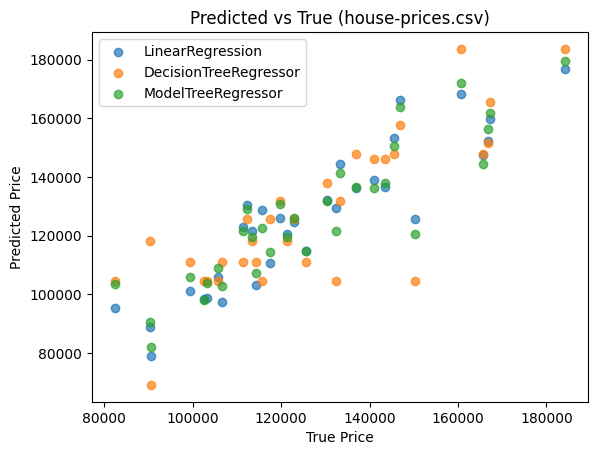

In [22]:
plt.figure()
plt.scatter(yh_test, pred_lin, alpha=0.7, label="LinearRegression")
plt.scatter(yh_test, pred_tree, alpha=0.7, label="DecisionTreeRegressor")
plt.scatter(yh_test, pred_m5, alpha=0.7, label="ModelTreeRegressor")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs True (house-prices.csv)")
plt.legend()
plt.show()

## B2. Sensitivity analysis: smoothing strength

A practical question in model trees is: “How much smoothing should I apply?”

- Low smoothing: more flexible, can overfit
- High smoothing: more stable, can underfit

We compute RMSE for several `smoothing_k` values and plot them.

In a production workflow, you’d pick this via cross-validation (not a single split), but a sweep is useful for intuition.

In [23]:
ks = [0, 5, 10, 15, 25, 40, 80]
rows = []

for k in ks:
    m = ModelTreeRegressor(max_depth=4, min_samples_leaf=5, ridge_alpha=1.0, smoothing_k=float(k), random_state=42)
    m.fit(Xh_train_enc, yh_train.to_numpy())
    pred = m.predict(Xh_test_enc)
    rows.append(regression_metrics(yh_test, pred, f"ModelTree k={k}"))

df_k = pd.DataFrame(rows)
df_k

,model,MAE,RMSE,R2
0,ModelTree k=0,9642.392200,13143.795636,0.718182
1,ModelTree k=5,8379.675599,10993.484252,0.802849
2,ModelTree k=10,8239.765258,10682.379758,0.813850
3,ModelTree k=15,8179.733921,10560.639368,0.818068
4,ModelTree k=25,8120.685581,10456.961717,0.821623
5,ModelTree k=40,8099.507282,10396.652579,0.823675
6,ModelTree k=80,8085.869945,10345.691657,0.825399


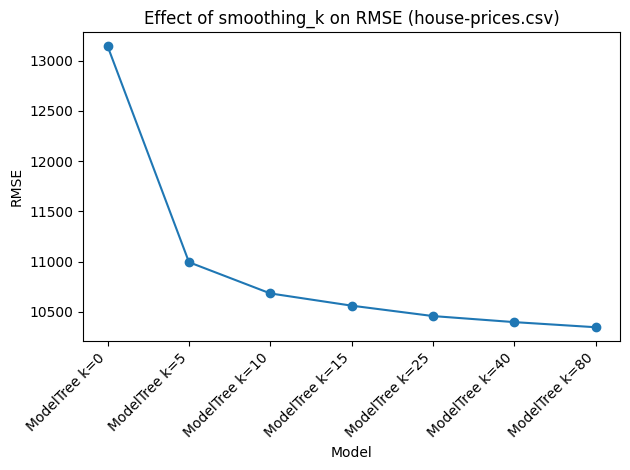

In [24]:
plt.figure()
plt.plot(df_k["model"], df_k["RMSE"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Effect of smoothing_k on RMSE (house-prices.csv)")
plt.tight_layout()
plt.show()

## B3. Inspecting a leaf model (interpretability)

Model trees remain interpretable because you can open a leaf and see:

- which features matter locally (coefficients)
- how coefficients differ across regions

Below we pick one test sample, trace its path to a leaf, and print the top coefficients in that leaf’s Ridge model.

Interpretation tip:
- Large absolute coefficients suggest strong local influence
- Compare the sign and magnitude to domain expectations

In [25]:
# Inspect one prediction path and show ridge coefficients of the leaf model.
i = 0
x_row = Xh_test_enc[i].toarray().ravel() if hasattr(Xh_test_enc, "toarray") else np.asarray(Xh_test_enc[i]).ravel()

path = m5._path_to_leaf(x_row)
leaf_id = path[-1]
print("Path node ids:", path)
print("Leaf node id:", leaf_id)
print("Leaf sample count:", m5.node_counts_.get(leaf_id))

leaf_model = m5.node_models_.get(leaf_id)
if leaf_model is None:
    print("Leaf model is None (fallback to mean).")
else:
    # Feature names from one-hot encoder + numeric passthrough
    ohe = preprocess_h.named_transformers_["cat"]
    cat_feature_names = []
    if hasattr(ohe, "get_feature_names_out"):
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols_h))
    feature_names = cat_feature_names + num_cols_h

    coefs = pd.Series(leaf_model.coef_, index=feature_names).sort_values(key=lambda s: np.abs(s), ascending=False)
    print("\nTop 10 absolute coefficients in leaf model:")
    display(coefs.head(10))

Path node ids: [0, np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Leaf node id: 4
Leaf sample count: 7

Top 10 absolute coefficients in leaf model:


Brick_Yes             2833.132013
Brick_No             -2833.132013
Offers               -2294.097762
Neighborhood_East      649.029372
Neighborhood_North    -649.029372
Bedrooms               340.153900
SqFt                    36.964216
Home                    12.816964
Neighborhood_West        0.000000
Bathrooms                0.000000
dtype: float64

---

## B4. Dataset 4 (regression): `diamonds.csv`

**Path:** `../../../Datasets/Regression/diamonds.csv`

This dataset is larger and more realistic. It has:
- numeric features (carat, dimensions)
- categorical features (cut/color/clarity)

We sample if necessary for speed.

We again compare:
- global Ridge regression
- regression tree
- model tree

The point is not to “win a Kaggle competition” but to build intuition about when model trees help.

In [26]:
dia_path = Path("../../../Datasets/Regression/diamonds.csv")
df_dia = pd.read_csv(dia_path)

if "id" in df_dia.columns:
    df_dia = df_dia.drop(columns=["id"])

# Subsample for speed if large
if len(df_dia) > 20000:
    df_dia = df_dia.sample(20000, random_state=42).reset_index(drop=True)

df_dia.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
1,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
2,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
3,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
4,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [27]:
target_d = "price"
Xd = df_dia.drop(columns=[target_d])
yd = df_dia[target_d].astype(float)

cat_cols_d = [c for c in Xd.columns if Xd[c].dtype == "object"]
num_cols_d = [c for c in Xd.columns if c not in cat_cols_d]

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    Xd, yd, test_size=0.25, random_state=42
)

preprocess_d = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_d),
        ("num", "passthrough", num_cols_d),
    ]
)

Xd_train_enc = preprocess_d.fit_transform(Xd_train)
Xd_test_enc = preprocess_d.transform(Xd_test)

print("Encoded train shape:", Xd_train_enc.shape)

Encoded train shape: (15000, 26)


In [28]:
lin_d = Ridge(alpha=1.0, random_state=42)
lin_d.fit(Xd_train_enc, yd_train.to_numpy())
pred_lin_d = lin_d.predict(Xd_test_enc)

tree_d = DecisionTreeRegressor(max_depth=7, min_samples_leaf=30, random_state=42)
tree_d.fit(Xd_train_enc, yd_train.to_numpy())
pred_tree_d = tree_d.predict(Xd_test_enc)

m5_d = ModelTreeRegressor(max_depth=7, min_samples_leaf=60, ridge_alpha=2.0, smoothing_k=30.0, random_state=42)
m5_d.fit(Xd_train_enc, yd_train.to_numpy())
pred_m5_d = m5_d.predict(Xd_test_enc)

pd.DataFrame([
    regression_metrics(yd_test, pred_lin_d, "Ridge (global)"),
    regression_metrics(yd_test, pred_tree_d, "DecisionTreeRegressor"),
    regression_metrics(yd_test, pred_m5_d, "ModelTreeRegressor (M5-like)"),
])

,model,MAE,RMSE,R2
0,Ridge (global),727.376542,1132.775146,0.918520
1,DecisionTreeRegressor,563.417429,1036.155799,0.931827
2,ModelTreeRegressor (M5-like),324.840570,604.353545,0.976808


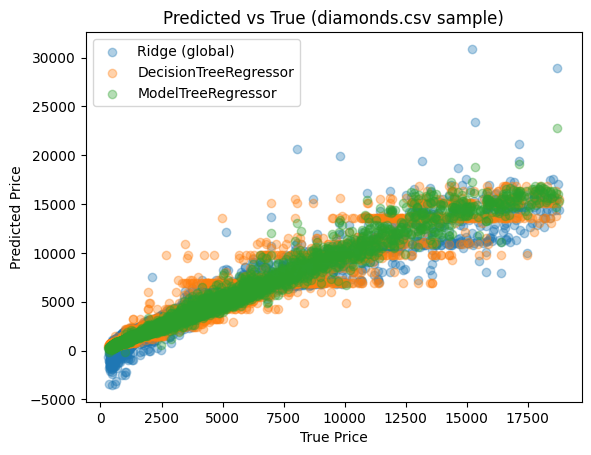

In [29]:
plt.figure()
plt.scatter(yd_test, pred_lin_d, alpha=0.35, label="Ridge (global)")
plt.scatter(yd_test, pred_tree_d, alpha=0.35, label="DecisionTreeRegressor")
plt.scatter(yd_test, pred_m5_d, alpha=0.35, label="ModelTreeRegressor")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs True (diamonds.csv sample)")
plt.legend()
plt.show()

---

## B5. Dataset 5 (regression): `European_Ski_Resorts.csv`

**Path:** `../../../Datasets/Regression/European_Ski_Resorts.csv`

We predict `DayPassPriceAdult` from a mix of numeric and categorical attributes (country, resort, slope totals, lift counts, etc.).

This dataset often contains missing values or weird columns; we include defensive cleaning:
- drop unnamed columns
- coerce the target to numeric and drop missing

Again, compare:
- global Ridge regression
- regression tree
- model tree

This third regression dataset reinforces the “not just one dataset” requirement and helps validate generality.

In [30]:
ski_path = Path("../../../Datasets/Regression/European_Ski_Resorts.csv")
df_ski = pd.read_csv(ski_path)
df_ski.head()

,Unnamed: 0,Resort,Country,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
0,1,Alpendorf (Ski amedé),Austria,1980,740,52,30,81,4,115,Yes,No,22,16,11,49,75398,600
1,2,Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...,Andorra,2640,1710,47,100,77,33,210,Yes,Yes,37,28,7,72,99017,1032
2,3,Oberau (Wildschönau),Austria,1130,900,30,1,0,1,2,No,No,2,0,0,2,1932,0
3,4,Dachstein West,Austria,1620,780,42,15,33,3,51,Yes,Yes,25,8,3,36,32938,163
4,5,Rosa Khutor,Southern Russia,2320,940,22,30,26,21,77,Yes,No,6,11,10,27,49228,450


In [31]:
# Predict DayPassPriceAdult as a regression target (tabular mixed types)
target_sk = "DayPassPriceAdult"

# Some files may have an unnamed index column; drop if exists
unnamed_cols = [c for c in df_ski.columns if c.startswith("Unnamed") or c == ""]
if unnamed_cols:
    df_ski = df_ski.drop(columns=unnamed_cols)

# Coerce target to numeric, drop missing
df_ski[target_sk] = pd.to_numeric(df_ski[target_sk], errors="coerce")
df_ski = df_ski.dropna(subset=[target_sk]).reset_index(drop=True)

Xsk = df_ski.drop(columns=[target_sk])
ysk = df_ski[target_sk].astype(float)

cat_cols_sk = [c for c in Xsk.columns if Xsk[c].dtype == "object"]
num_cols_sk = [c for c in Xsk.columns if c not in cat_cols_sk]

Xsk_train, Xsk_test, ysk_train, ysk_test = train_test_split(
    Xsk, ysk, test_size=0.25, random_state=42
)

preprocess_sk = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_sk),
        ("num", "passthrough", num_cols_sk),
    ]
)

Xsk_train_enc = preprocess_sk.fit_transform(Xsk_train)
Xsk_test_enc = preprocess_sk.transform(Xsk_test)

print("Encoded shape:", Xsk_train_enc.shape)

Encoded shape: (282, 322)


In [32]:
lin_sk = Ridge(alpha=1.0, random_state=42)
lin_sk.fit(Xsk_train_enc, ysk_train.to_numpy())
pred_lin_sk = lin_sk.predict(Xsk_test_enc)

tree_sk = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, random_state=42)
tree_sk.fit(Xsk_train_enc, ysk_train.to_numpy())
pred_tree_sk = tree_sk.predict(Xsk_test_enc)

m5_sk = ModelTreeRegressor(max_depth=6, min_samples_leaf=15, ridge_alpha=2.0, smoothing_k=25.0, random_state=42)
m5_sk.fit(Xsk_train_enc, ysk_train.to_numpy())
pred_m5_sk = m5_sk.predict(Xsk_test_enc)

pd.DataFrame([
    regression_metrics(ysk_test, pred_lin_sk, "Ridge (global)"),
    regression_metrics(ysk_test, pred_tree_sk, "DecisionTreeRegressor"),
    regression_metrics(ysk_test, pred_m5_sk, "ModelTreeRegressor (M5-like)"),
])

,model,MAE,RMSE,R2
0,Ridge (global),4.830074,6.061398,0.721777
1,DecisionTreeRegressor,5.587395,7.811583,0.537912
2,ModelTreeRegressor (M5-like),4.795535,6.662670,0.663842


---

# Wrap-up: what to take away

## Key takeaways

1. **CHAID** is best understood as *contingency-table + hypothesis test splitting*.
   - Great for categorical predictors and report-style interpretability
   - Needs guardrails (category merging, multiple testing correction, stability checks)

2. **M5 model trees** are a practical upgrade for regression:
   - retain the tree partitioning for interactions/nonlinearities
   - replace constant leaves with linear models (piecewise linear)
   - smoothing is a controllable knob for stability vs flexibility

## Suggested next steps (for your repo quality)

- Move reusable code into `utils/chaid.py` and `utils/model_tree.py`.
- Add a small `tests/` folder to sanity-check:
  - CHAID split scoring on known contingency tables
  - model tree prediction shape and determinism for fixed seeds
- Add a “benchmark notebook” per chapter that runs a consistent evaluation protocol.

## Exercises (extend the notebook)

1. Implement Bonferroni correction at each node: $\\alpha' = \\alpha/m$.
2. Implement category merging:
   - compute pairwise $p$-values between categories
   - merge the least distinguishable categories iteratively
3. Implement supervised discretization for numeric features.
4. Replace Ridge in leaf models with Lasso or Elastic Net and observe effects.
5. Add cross-validation selection of `smoothing_k` and `max_depth`.

If you want, I can generate a clean `utils/` package + accompanying notebooks in both languages.